# Inspect the single-lineage model run on the prostate data

Model attributes:

- sgRNA | gene varying intercept
- RNA and CN varying effects per gene
- correlation between gene varying effects modeled using the multivariate normal and Cholesky decomposition (non-centered parameterization)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qnorm
import seaborn as sns

In [3]:
from speclet.analysis.arviz_analysis import extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import modeling_data_dir, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"
arviz_config()

## Data

### Load posterior summary

In [5]:
prostate_post_summary = pd.read_csv(
    models_dir() / "hnb-single-lineage-prostate_PYMC_NUMPYRO" / "posterior-summary.csv"
).assign(var_name=lambda d: [x.split("[")[0] for x in d["parameter"]])
prostate_post_summary.head()

parameter    mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
0   mu_mu_a   0.067  0.002     0.063      0.070      0.000      0.0    1227.0   
1      mu_b   0.004  0.001     0.003      0.005      0.000      0.0    3867.0   
2      mu_d  -0.021  0.001    -0.022     -0.019      0.000      0.0    5181.0   
3   sigma_a   0.207  0.001     0.205      0.208      0.000      0.0    1658.0   
4     alpha  11.645  0.036    11.588     11.703      0.001      0.0    2783.0   

   ess_tail  r_hat var_name  
0    2168.0    1.0  mu_mu_a  
1    3730.0    1.0     mu_b  
2    3502.0    1.0     mu_d  
3    3055.0    1.0  sigma_a  
4    2928.0    1.0    alpha

### Load trace object

In [6]:
trace_file = (
    models_dir() / "hnb-single-lineage-prostate_PYMC_NUMPYRO" / "posterior.netcdf"
)
assert trace_file.exists()
trace = az.from_netcdf(trace_file)

### Prostate data

In [7]:
def _broad_only(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["screen"] == "broad"].reset_index(drop=True)


prostate_dm = CrisprScreenDataManager(
    modeling_data_dir() / "lineage-modeling-data" / "depmap-modeling-data_prostate.csv",
    transformations=[_broad_only],
)

In [8]:
prostate_data = prostate_dm.get_data(read_kwargs={"low_memory": False})
prostate_data.head()

sgrna                 replicate_id       lfc p_dna_batch  \
0  AAAGCCCAGGAGTATGGGAG  Vcap-304Cas9_RepA_p4_batch3  0.246450           3   
1  AAATCAGAGAAACCTGAACG  Vcap-304Cas9_RepA_p4_batch3  0.626518           3   
2  AACGTCTTTGAAGAAAGCTG  Vcap-304Cas9_RepA_p4_batch3  0.165114           3   
3  AACGTCTTTGAAGGAAGCTG  Vcap-304Cas9_RepA_p4_batch3 -0.094688           3   
4  AAGAGGTTCCAGACTACTTA  Vcap-304Cas9_RepA_p4_batch3  0.294496           3   

   genome_alignment hugo_symbol screen  multiple_hits_on_gene  \
0  chr2_130522105_-       CFC1B  broad                   True   
1  chr11_89916950_-    TRIM49D1  broad                   True   
2   chr5_71055421_-      GTF2H2  broad                   True   
3   chr5_69572480_+     GTF2H2C  broad                   True   
4  chrX_155898173_+       VAMP7  broad                   True   

  sgrna_target_chr  sgrna_target_pos  ... any_deleterious  any_tcga_hotspot  \
0                2         130522105  ...             NaN               NaN   
1               11          89916950  ...             NaN               NaN   
2                5          71055421  ...             NaN               NaN   
3                5          69572480  ...             NaN               NaN   
4                X         155898173  ...             NaN               NaN   

   any_cosmic_hotspot  is_mutated  copy_number   lineage  \
0                 NaN       False     0.999455  prostate   
1                 NaN       False     1.281907  prostate   
2                 NaN       False     0.616885  prostate   
3                 NaN       False     0.616885  prostate   
4                 NaN       False     0.615935  prostate   

           lineage_subtype primary_or_metastasis  is_male   age  
0  prostate_adenocarcinoma            metastasis     True  59.0  
1  prostate_adenocarcinoma            metastasis     True  59.0  
2  prostate_adenocarcinoma            metastasis     True  59.0  
3  prostate_adenocarcinoma            metastasis     True  59.0  
4  prostate_adenocarcinoma            metastasis     True  59.0  

[5 rows x 25 columns]

### Single lineage model

In [9]:
prostate_model = LineageHierNegBinomModel(lineage="prostate")

In [10]:
valid_prostate_data = prostate_model.data_processing_pipeline(prostate_data.copy())
prostate_mdl_data = prostate_model.make_data_structure(valid_prostate_data)

[07/24/22 17:53:58] INFO     Processing data for modeling.     ]8;id=280931;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=337633;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#268\268]8;;\

                    INFO     LFC limits: (-5.0, 5.0)           ]8;id=634739;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=518420;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#269\269]8;;\

[07/24/22 17:55:18] WARNING  number of data points dropped: 2  ]8;id=970634;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py\lineage_hierarchical_nb.py]8;;\:]8;id=189950;file:///n/data1/hms/dbmi/park/Cook/speclet/speclet/bayesian_models/lineage_hierarchical_nb.py#320\320]8;;\

## Analysis

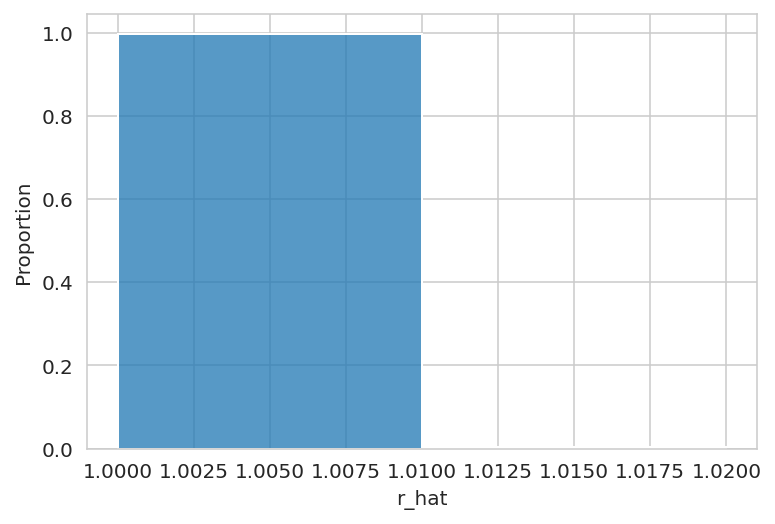

In [11]:
sns.histplot(x=prostate_post_summary["r_hat"], binwidth=0.01, stat="proportion");

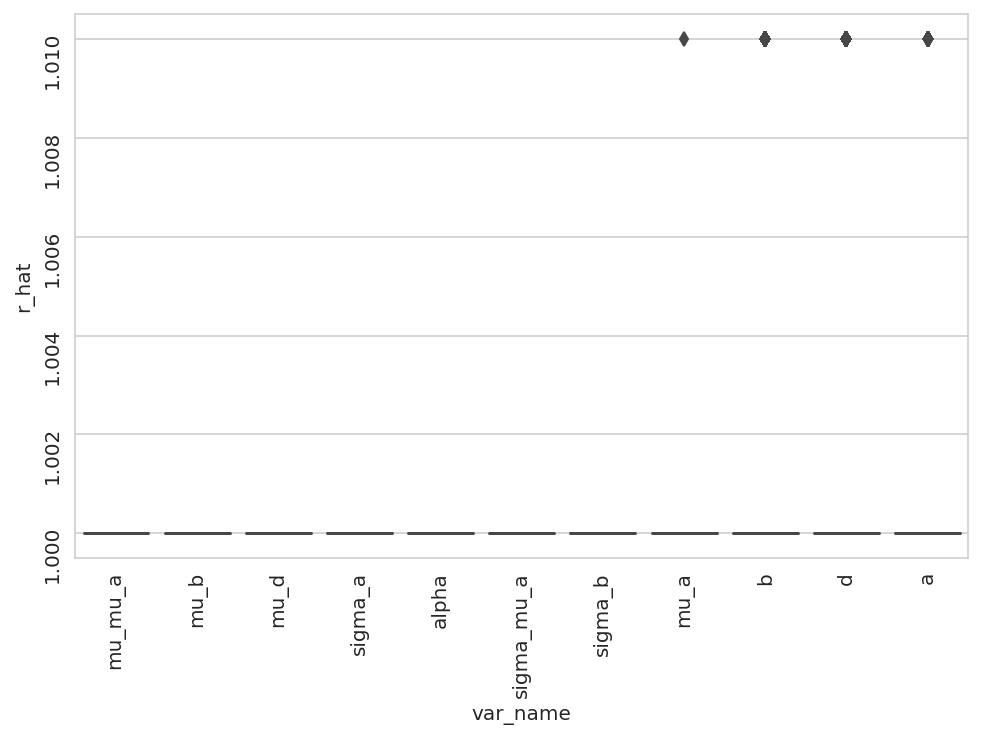

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=prostate_post_summary, x="var_name", y="r_hat", ax=ax)
ax.tick_params(rotation=90)
plt.show()

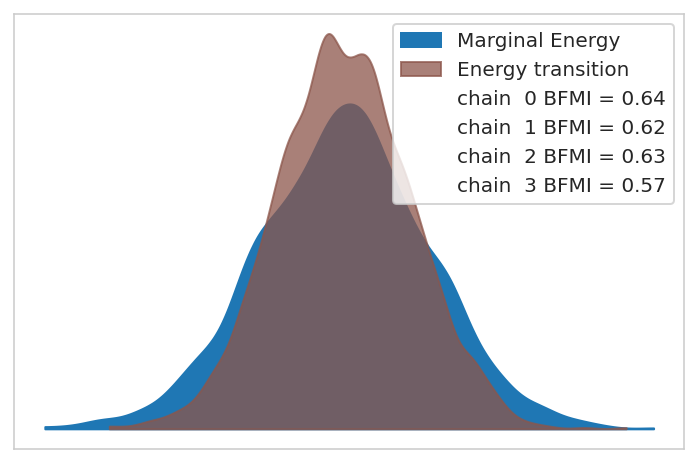

In [13]:
az.plot_energy(trace);

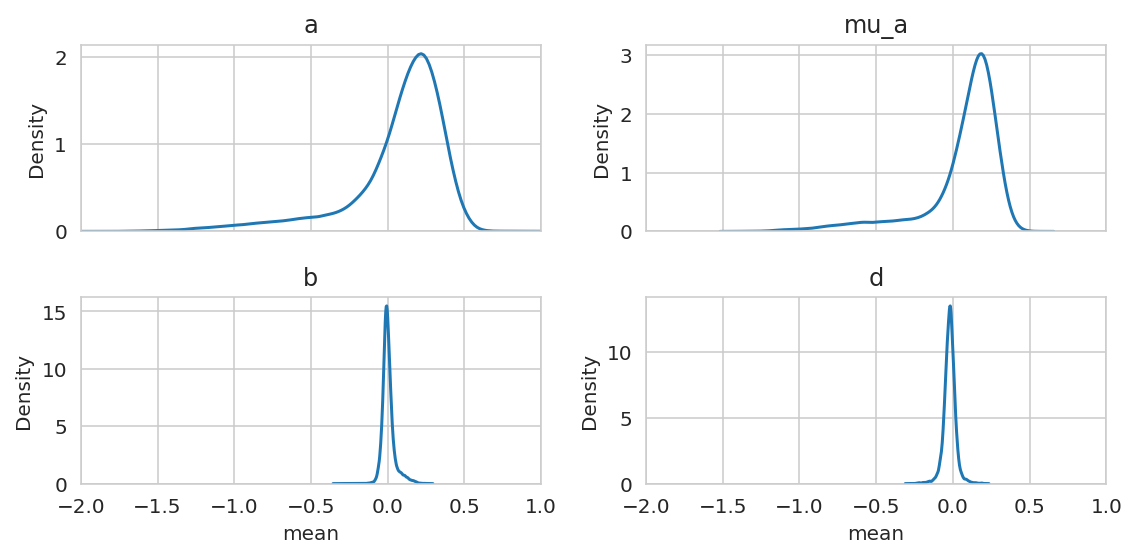

In [14]:
var_names = ["a", "mu_a", "b", "d"]
_, axes = plt.subplots(2, 2, figsize=(8, 4), sharex=True)
for ax, var_name in zip(axes.flatten(), var_names):
    x = prostate_post_summary.query(f"var_name == '{var_name}'")["mean"]
    sns.kdeplot(x=x, ax=ax)
    ax.set_title(var_name)
    ax.set_xlim(-2, 1)

plt.tight_layout()
plt.show()

In [15]:
sgrna_to_gene_map = (
    prostate_data.copy()[["hugo_symbol", "sgrna"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

In [16]:
(
    prostate_post_summary.query("var_name == 'mu_a'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(head_tail, n=5)
)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0            mu_a[RAN] -1.408  0.115    -1.592     -1.228      0.002    0.001   
1          mu_a[KIF11] -1.393  0.116    -1.571     -1.198      0.002    0.001   
2          mu_a[HSPE1] -1.349  0.114    -1.526     -1.171      0.002    0.001   
3          mu_a[RPL12] -1.335  0.116    -1.523     -1.156      0.002    0.001   
4           mu_a[RPL9] -1.331  0.120    -1.522     -1.140      0.002    0.001   
18114     mu_a[ZNF611]  0.474  0.113     0.294      0.652      0.002    0.001   
18115  mu_a[TMPRSS11F]  0.478  0.124     0.269      0.663      0.002    0.001   
18116      mu_a[EPHA2]  0.483  0.112     0.313      0.665      0.002    0.001   
18117      mu_a[FOPNL]  0.485  0.113     0.307      0.660      0.002    0.001   
18118        mu_a[NF2]  0.548  0.109     0.373      0.723      0.002    0.001   

       ess_bulk  ess_tail  r_hat var_name  
0        3909.0    3423.0    1.0     mu_a  
1        3788.0    3251.0    1.0     mu_a  
2        3243.0    3023.0    1.0     mu_a  
3        3860.0    3421.0    1.0     mu_a  
4        3717.0    3141.0    1.0     mu_a  
18114    3686.0    3389.0    1.0     mu_a  
18115    4188.0    3280.0    1.0     mu_a  
18116    3568.0    3387.0    1.0     mu_a  
18117    3389.0    3001.0    1.0     mu_a  
18118    3743.0    2969.0    1.0     mu_a

In [17]:
(
    prostate_post_summary.query("var_name == 'b'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(head_tail, n=5)
)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0      b[EP300] -0.339  0.046    -0.412     -0.265      0.001      0.0   
1        b[EBP] -0.195  0.047    -0.268     -0.121      0.001      0.0   
2      b[STAG2] -0.188  0.043    -0.254     -0.117      0.000      0.0   
3       b[TP63] -0.171  0.043    -0.242     -0.104      0.000      0.0   
4      b[FOXA1] -0.171  0.046    -0.245     -0.100      0.000      0.0   
18114  b[DDX10]  0.256  0.046     0.181      0.326      0.000      0.0   
18115  b[EIF5A]  0.256  0.046     0.177      0.326      0.001      0.0   
18116   b[GRB2]  0.266  0.045     0.196      0.339      0.000      0.0   
18117  b[AIFM1]  0.275  0.047     0.204      0.353      0.001      0.0   
18118  b[NARS2]  0.278  0.045     0.203      0.348      0.000      0.0   

       ess_bulk  ess_tail  r_hat var_name  
0        7682.0    3174.0   1.00        b  
1        8111.0    3184.0   1.00        b  
2        8419.0    2570.0   1.00        b  
3       10551.0    3238.0   1.00        b  
4        9048.0    2763.0   1.00        b  
18114   10787.0    2761.0   1.00        b  
18115    8467.0    2666.0   1.00        b  
18116   10893.0    2799.0   1.01        b  
18117    8404.0    2681.0   1.00        b  
18118   10633.0    2554.0   1.00        b

In [18]:
(
    prostate_post_summary.query("var_name == 'd'")
    .sort_values("mean")
    .reset_index(drop=True)
    .pipe(head_tail, n=5)
)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
0      d[ATP1A1] -0.294  0.045    -0.362     -0.219        0.0      0.0   
1       d[TRIT1] -0.284  0.046    -0.355     -0.211        0.0      0.0   
2       d[LONP1] -0.283  0.043    -0.357     -0.220        0.0      0.0   
3       d[PARS2] -0.264  0.045    -0.334     -0.192        0.0      0.0   
4        d[DAP3] -0.255  0.044    -0.323     -0.180        0.0      0.0   
18114    d[PWP2]  0.193  0.044     0.123      0.266        0.0      0.0   
18115  d[MRPL10]  0.197  0.042     0.123      0.259        0.0      0.0   
18116  d[NDUFB9]  0.206  0.044     0.140      0.279        0.0      0.0   
18117  d[MRPL39]  0.211  0.043     0.138      0.275        0.0      0.0   
18118  d[TIMM10]  0.219  0.045     0.150      0.293        0.0      0.0   

       ess_bulk  ess_tail  r_hat var_name  
0        8588.0    3048.0    1.0        d  
1        9876.0    2834.0    1.0        d  
2       11391.0    2719.0    1.0        d  
3        9738.0    2559.0    1.0        d  
4        9926.0    3185.0    1.0        d  
18114    9439.0    2755.0    1.0        d  
18115    9262.0    2554.0    1.0        d  
18116   11233.0    2933.0    1.0        d  
18117    9246.0    3193.0    1.0        d  
18118   11211.0    2974.0    1.0        d

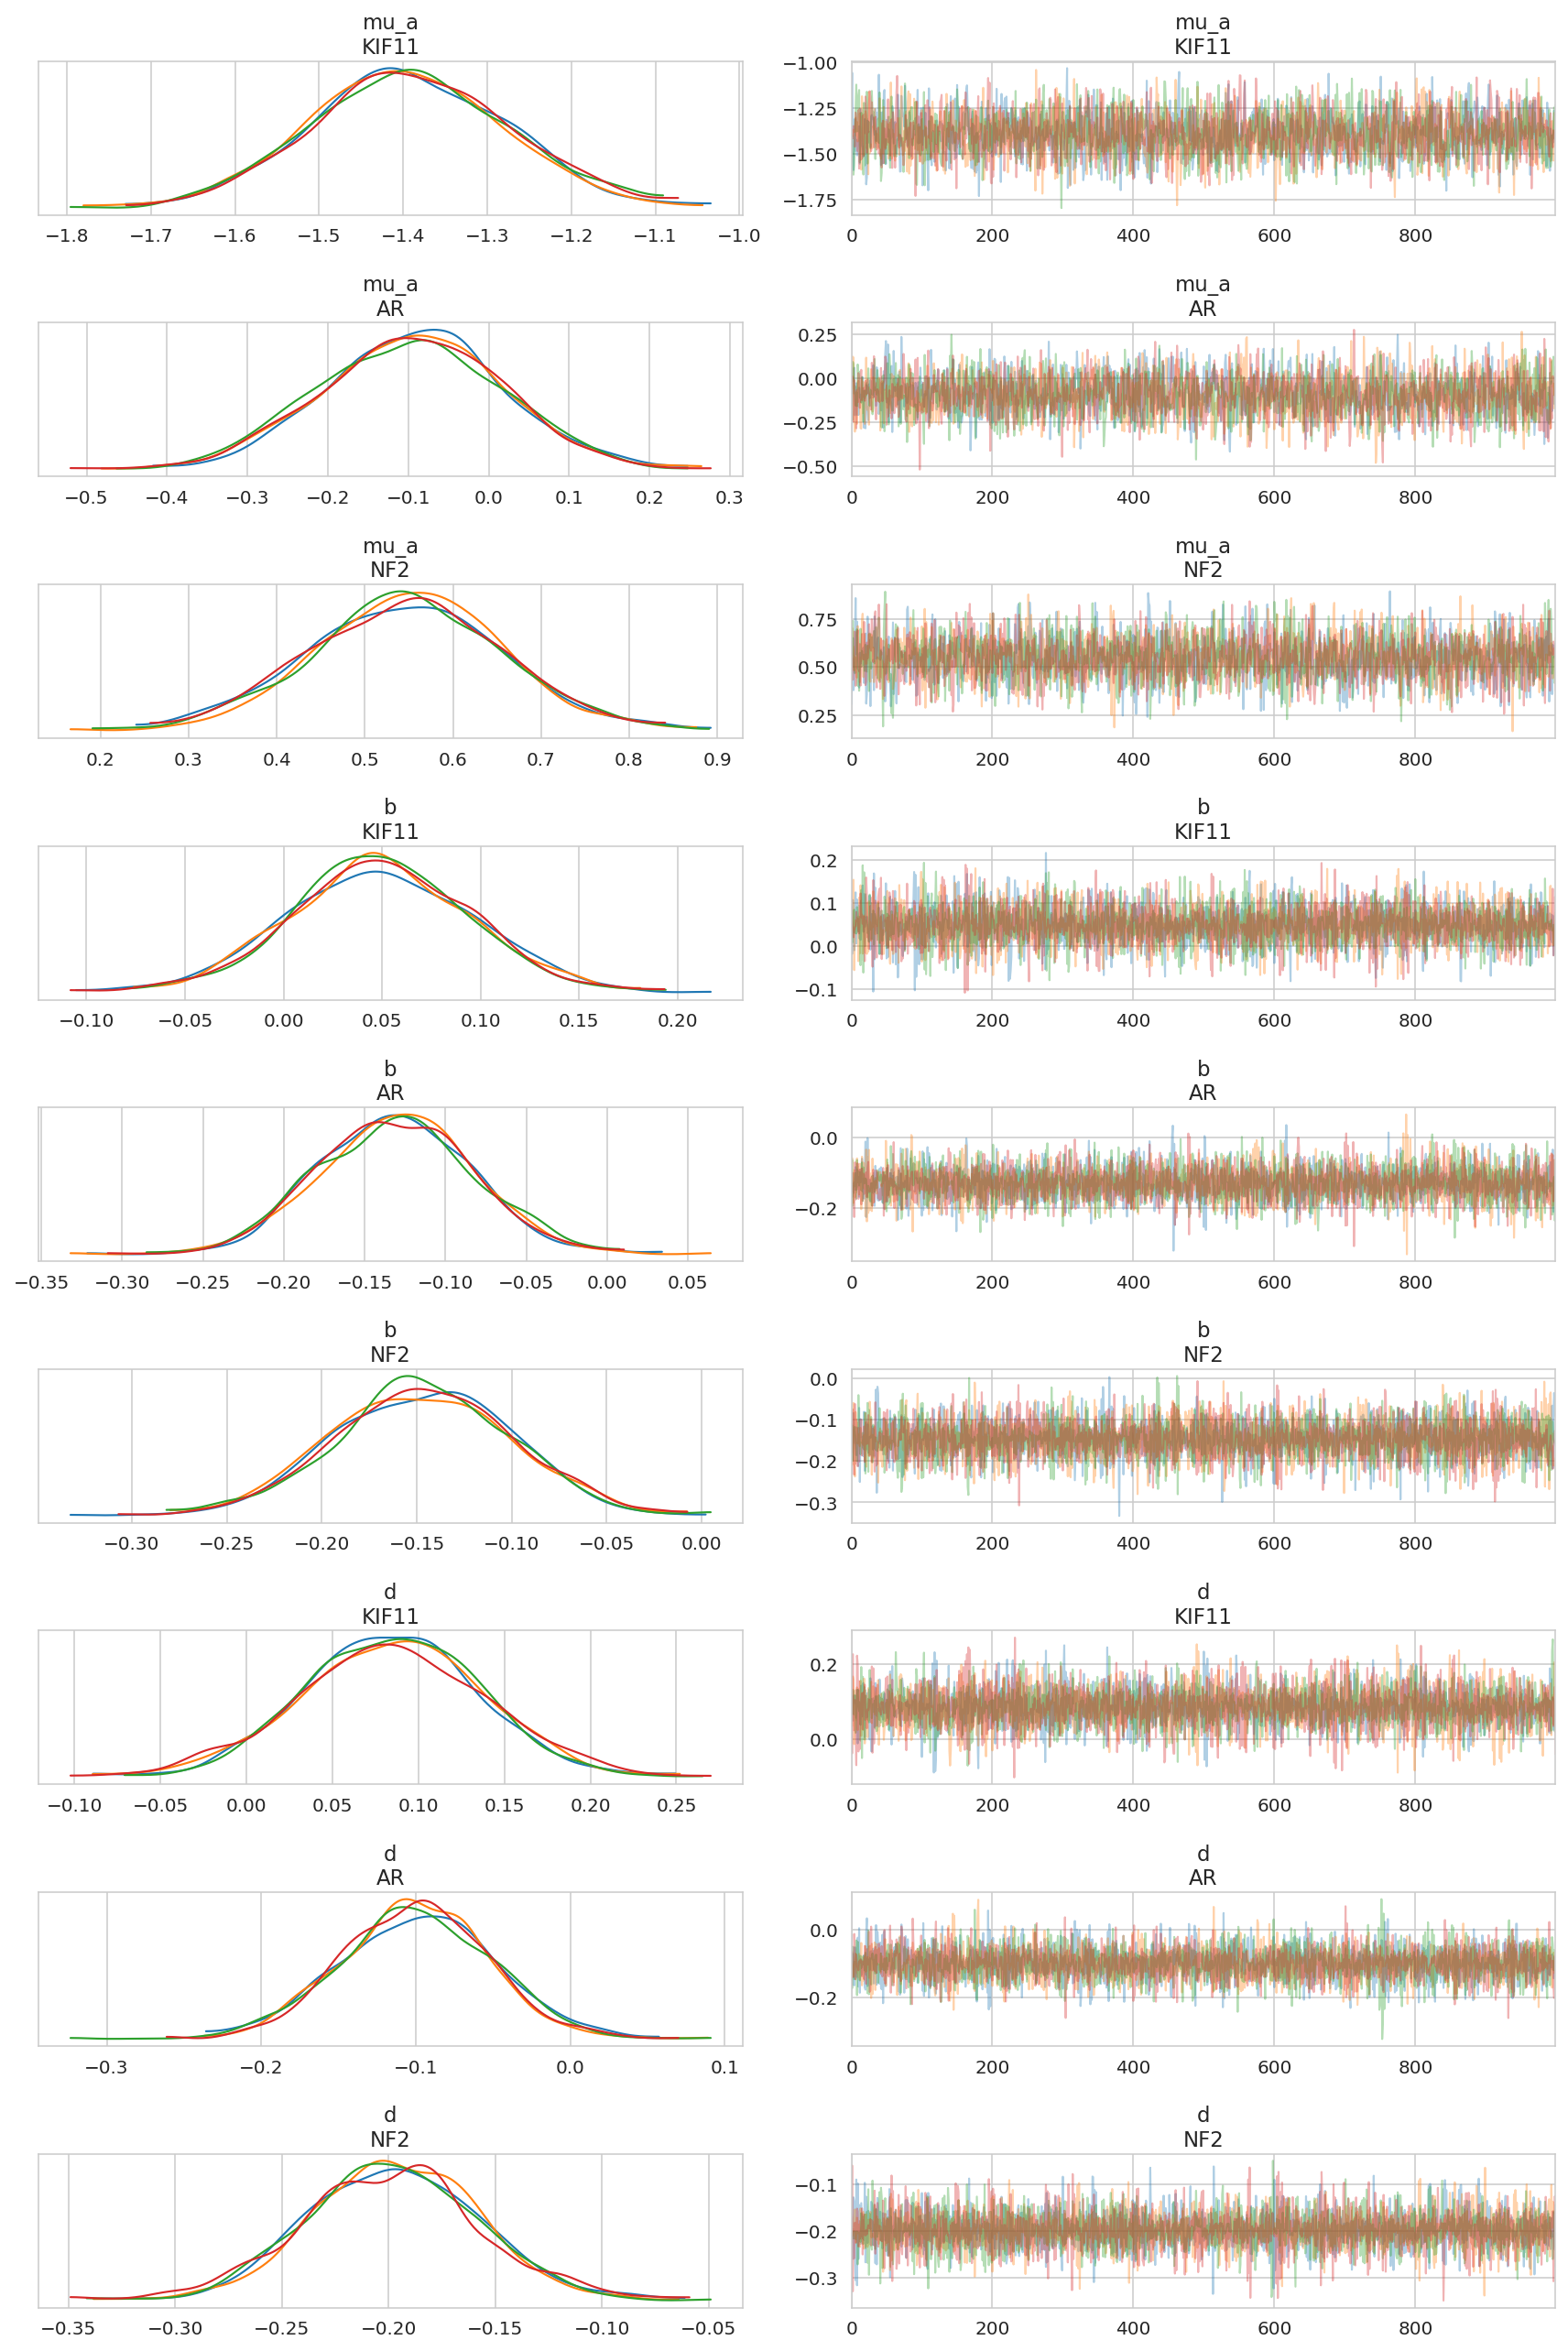

In [19]:
example_genes = ["KIF11", "AR", "NF2"]
az.plot_trace(
    trace, var_names=["mu_a", "b", "d"], coords={"gene": example_genes}, compact=False
)
plt.tight_layout()
plt.show()

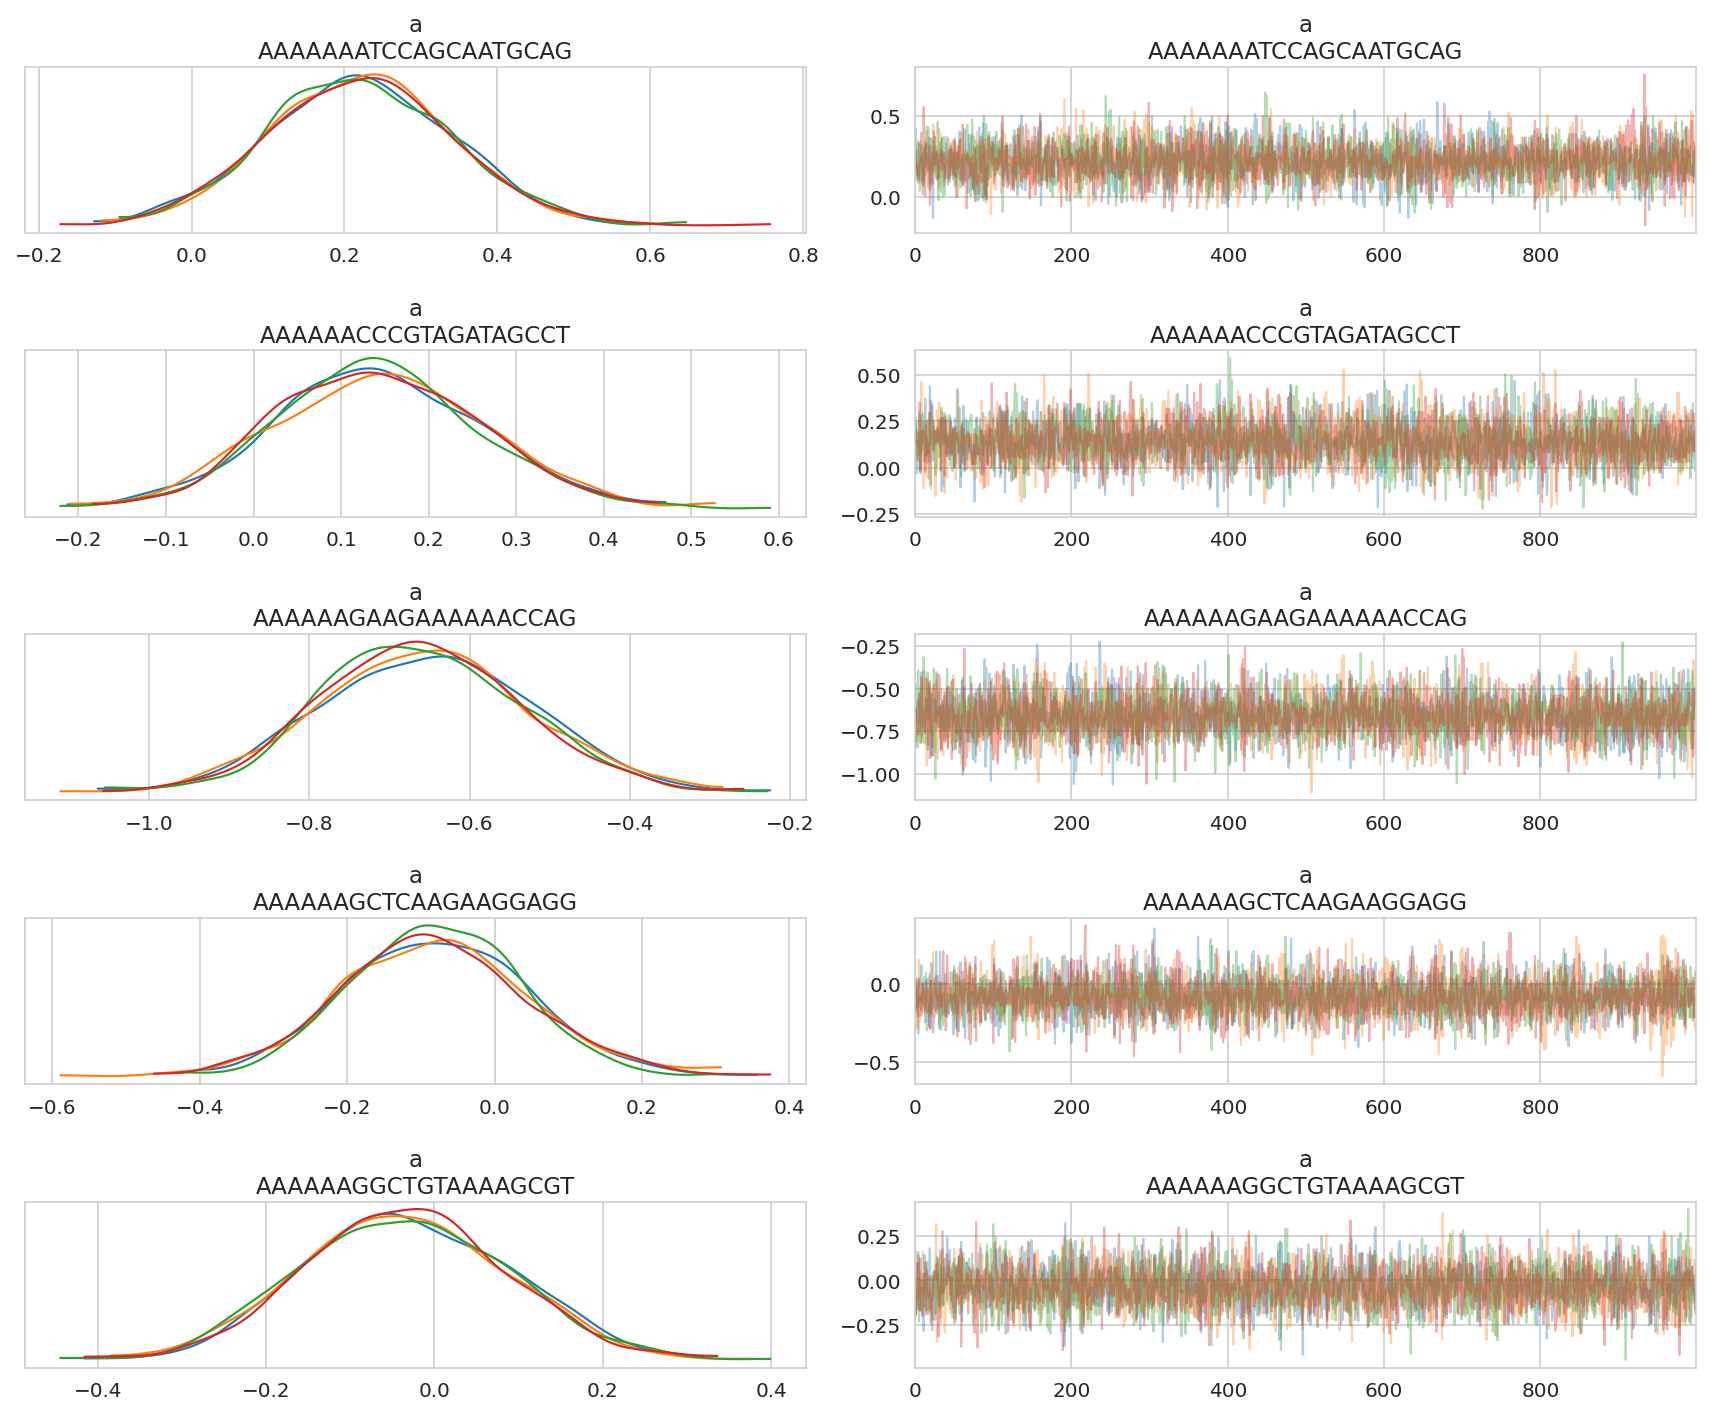

In [20]:
sgrnas_sample = trace.posterior.coords["sgrna"].values[:5]

az.plot_trace(trace, var_names="a", coords={"sgrna": sgrnas_sample}, compact=False)
plt.tight_layout()
plt.show()

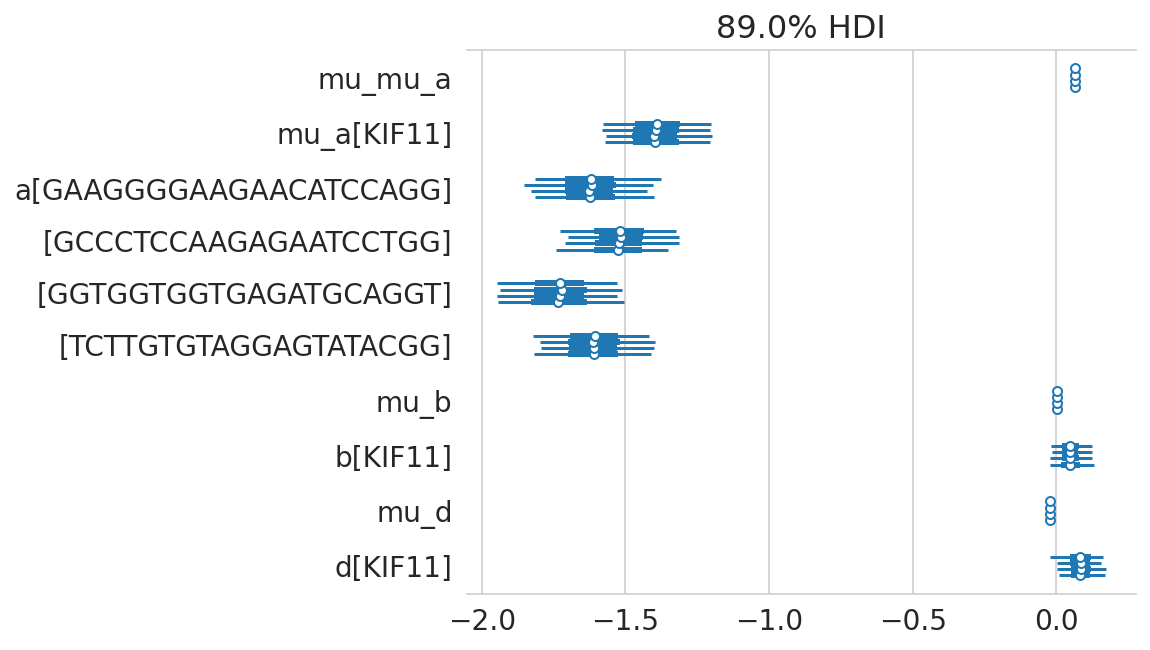

In [21]:
example_gene = "KIF11"
example_gene_sgrna = sgrna_to_gene_map.query(f"hugo_symbol == '{example_gene}'")[
    "sgrna"
].tolist()
az.plot_forest(
    trace,
    var_names=["mu_mu_a", "mu_a", "a", "mu_b", "b", "mu_d", "d"],
    coords={"gene": [example_gene], "sgrna": example_gene_sgrna},
    combined=False,
    figsize=(6, 5),
)
plt.show()

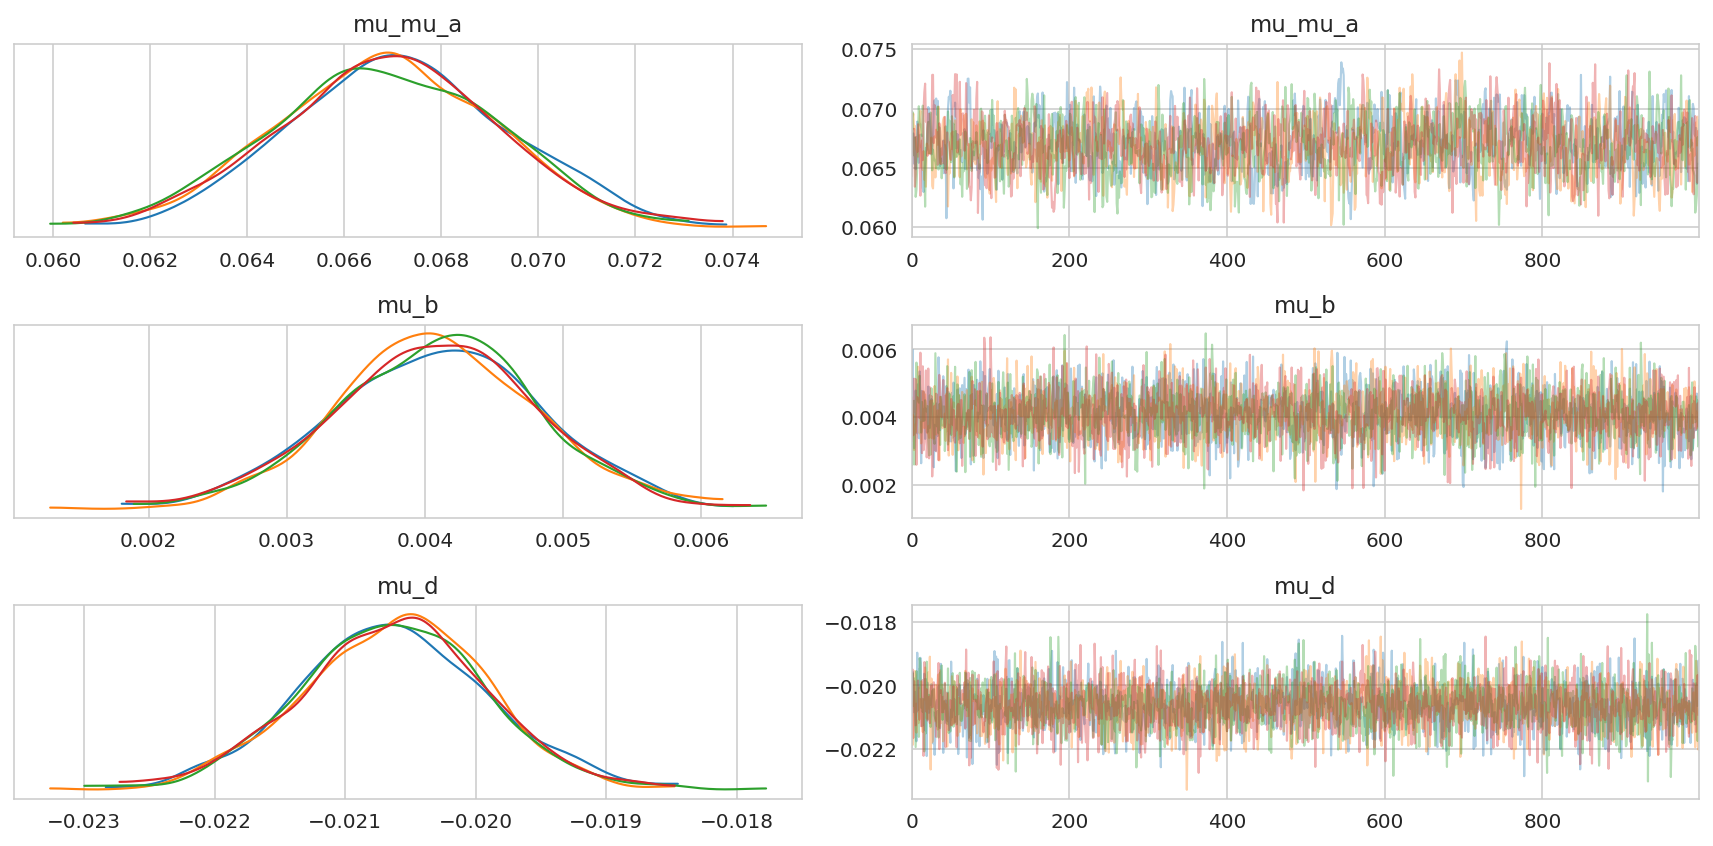

In [22]:
az.plot_trace(trace, var_names=["mu_mu_a", "mu_b", "mu_d"], compact=False)
plt.tight_layout()

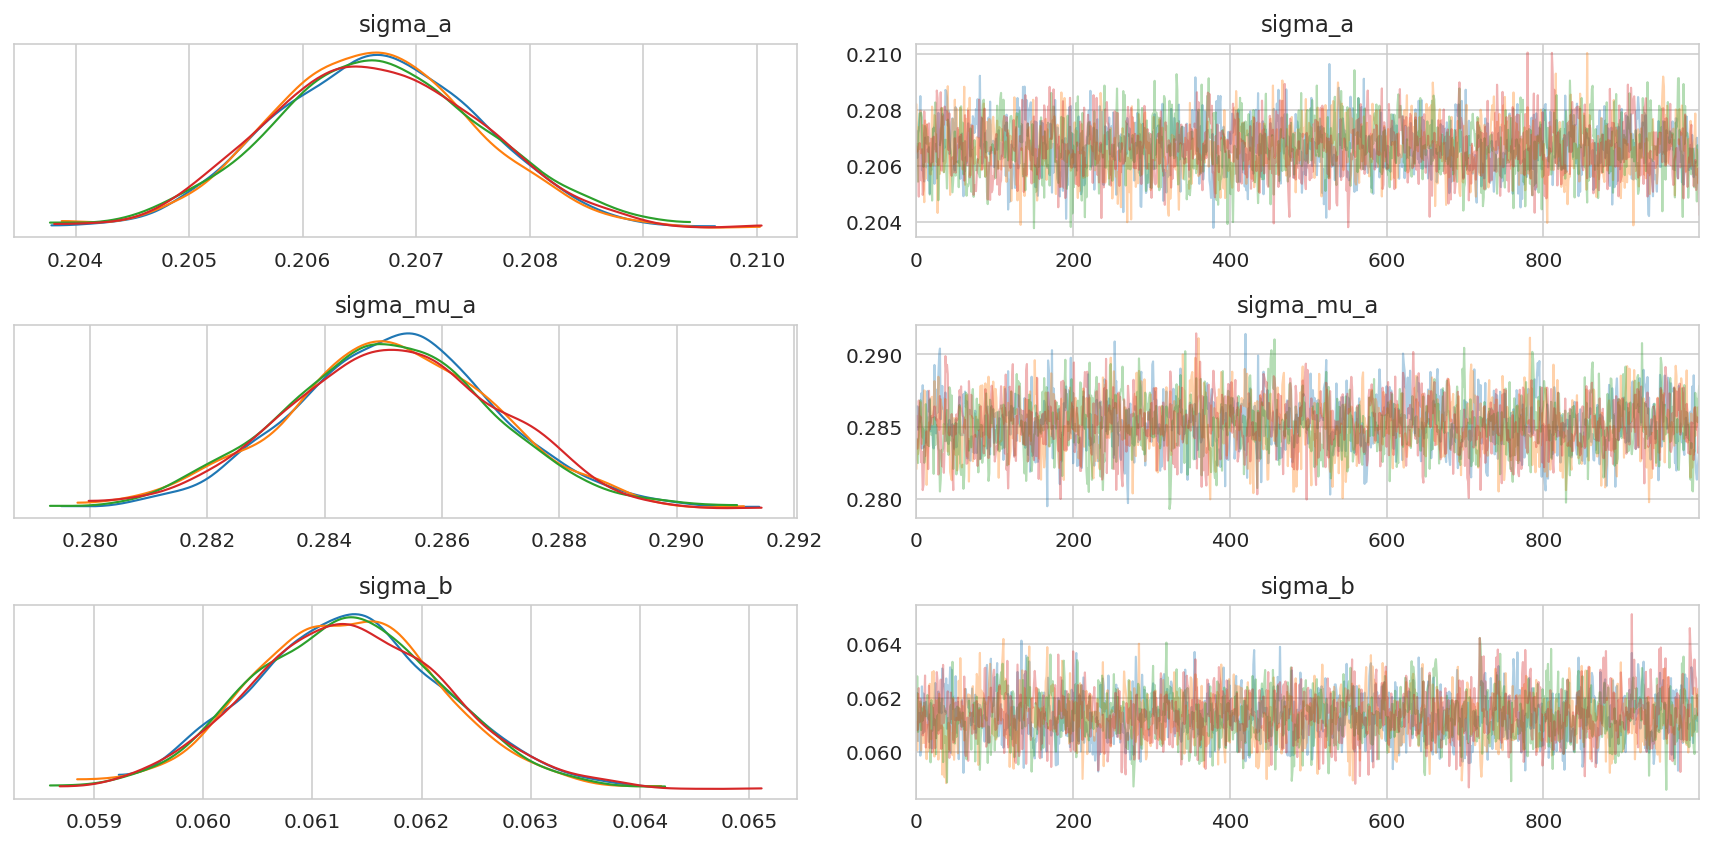

In [23]:
az.plot_trace(trace, var_names=["^sigma_*"], filter_vars="regex", compact=False)
plt.tight_layout()

In [24]:
prostate_post_summary.filter_string("var_name", "^sigma_*")

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
3     sigma_a  0.207  0.001     0.205      0.208        0.0      0.0   
5  sigma_mu_a  0.285  0.002     0.282      0.288        0.0      0.0   
6     sigma_b  0.061  0.001     0.060      0.063        0.0      0.0   

   ess_bulk  ess_tail  r_hat    var_name  
3    1658.0    3055.0    1.0     sigma_a  
5    1572.0    2262.0    1.0  sigma_mu_a  
6    1686.0    2896.0    1.0     sigma_b

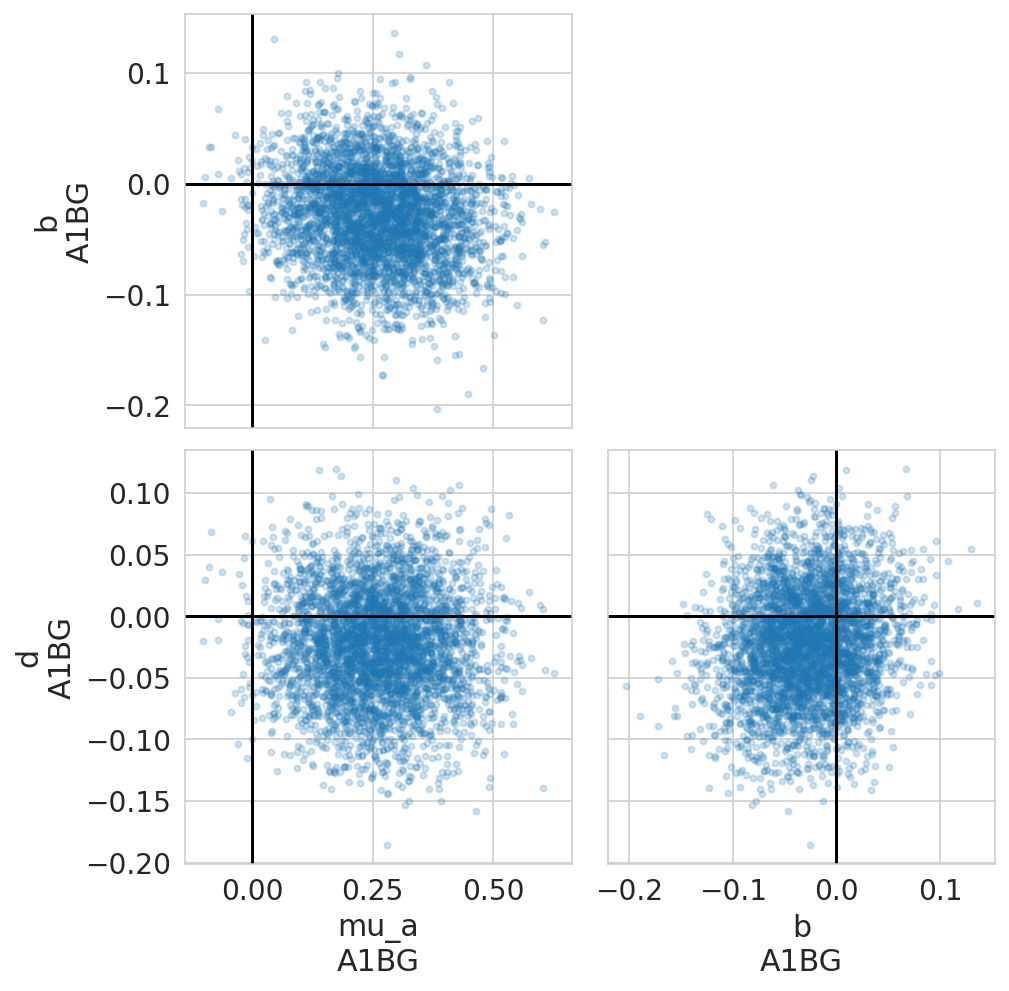

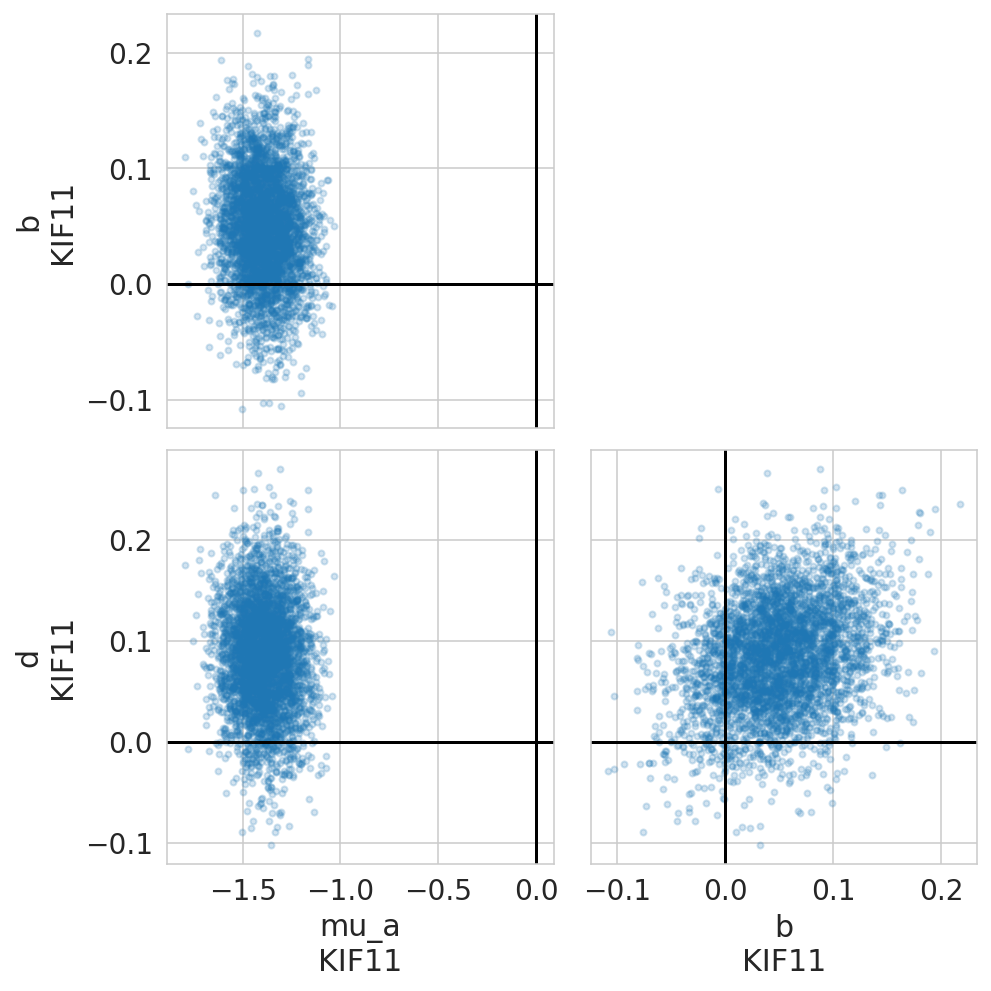

In [25]:
eg_gene = trace.posterior.coords["gene"].values[0]

for gene in [eg_gene, "KIF11"]:
    axes = az.plot_pair(
        trace,
        var_names=["mu_a", "b", "d"],
        coords={"gene": [gene]},
        figsize=(7, 7),
        scatter_kwargs={"alpha": 0.2},
    )
    for ax in axes.flatten():
        ax.axhline(0, color="k")
        ax.axvline(0, color="k")
    plt.tight_layout()
    plt.show()

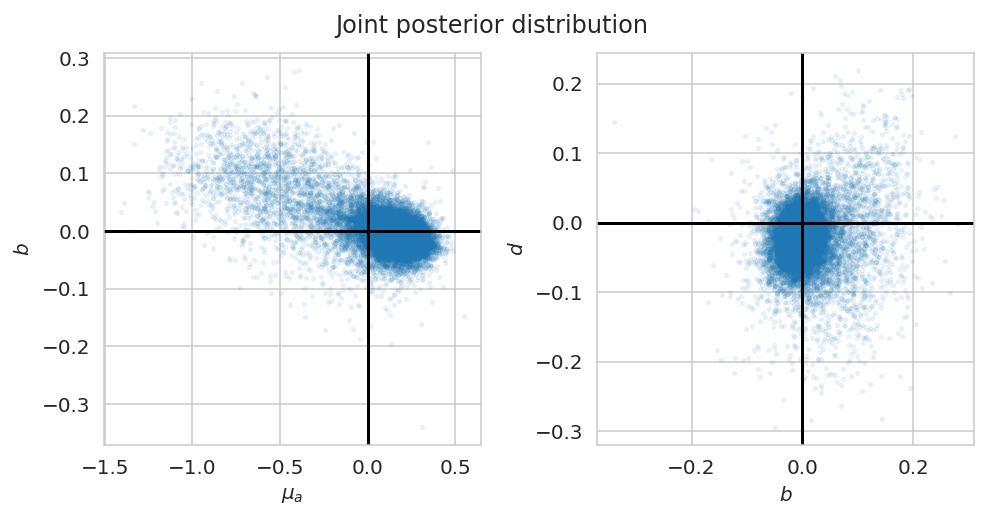

In [26]:
mu_a_post_avg = trace.posterior["mu_a"].mean(axis=(0, 1))
b_post_avg = trace.posterior["b"].mean(axis=(0, 1))
d_post_avg = trace.posterior["d"].mean(axis=(0, 1))


fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(7, 3.5))

ax = axes[0]
sns.scatterplot(x=mu_a_post_avg, y=b_post_avg, alpha=0.1, edgecolor=None, s=5, ax=ax)
ax.set_xlabel(r"$\mu_a$")
ax.set_ylabel(r"$b$")


ax = axes[1]
sns.scatterplot(x=b_post_avg, y=d_post_avg, alpha=0.1, edgecolor=None, s=5, ax=ax)
ax.set_xlabel(r"$b$")
ax.set_ylabel(r"$d$")

for ax in axes.flatten():
    ax.axhline(color="k")
    ax.axvline(color="k")

fig.tight_layout()
fig.suptitle("Joint posterior distribution", va="bottom")

plt.show()

In [28]:
genes_var_names = ["mu_a", "b", "d"]
gene_corr_post = (
    az.summary(trace, "genes_chol_cov_corr", kind="stats")
    .pipe(extract_coords_param_names, names=["d1", "d2"])
    .astype({"d1": int, "d2": int})
    .assign(
        p1=lambda d: [genes_var_names[i] for i in d["d1"]],
        p2=lambda d: [genes_var_names[i] for i in d["d2"]],
    )
)
gene_corr_post

mean     sd  hdi_5.5%  hdi_94.5%  d1  d2    p1  \
genes_chol_cov_corr[0, 0]  1.000  0.000     1.000      1.000   0   0  mu_a   
genes_chol_cov_corr[0, 1] -0.443  0.012    -0.462     -0.423   0   1  mu_a   
genes_chol_cov_corr[0, 2]  0.031  0.013     0.011      0.053   0   2  mu_a   
genes_chol_cov_corr[1, 0] -0.443  0.012    -0.462     -0.423   1   0     b   
genes_chol_cov_corr[1, 1]  1.000  0.000     1.000      1.000   1   1     b   
genes_chol_cov_corr[1, 2]  0.024  0.019    -0.007      0.054   1   2     b   
genes_chol_cov_corr[2, 0]  0.031  0.013     0.011      0.053   2   0     d   
genes_chol_cov_corr[2, 1]  0.024  0.019    -0.007      0.054   2   1     d   
genes_chol_cov_corr[2, 2]  1.000  0.000     1.000      1.000   2   2     d   

                             p2  
genes_chol_cov_corr[0, 0]  mu_a  
genes_chol_cov_corr[0, 1]     b  
genes_chol_cov_corr[0, 2]     d  
genes_chol_cov_corr[1, 0]  mu_a  
genes_chol_cov_corr[1, 1]     b  
genes_chol_cov_corr[1, 2]     d  
genes_chol_cov_corr[2, 0]  mu_a  
genes_chol_cov_corr[2, 1]     b  
genes_chol_cov_corr[2, 2]     d

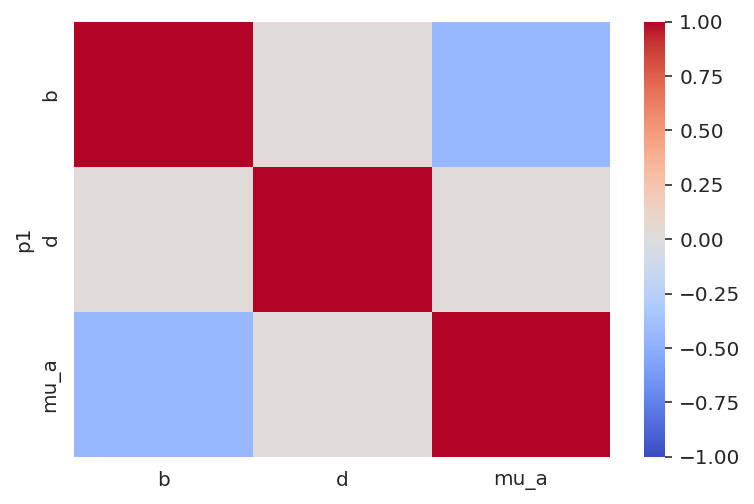

In [29]:
plot_df = gene_corr_post.pivot_wider("p1", "p2", "mean").set_index("p1")
sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

In [27]:
n_examples = 40
n_chains, n_draws, n_data = trace.posterior_predictive["ct_final"].shape
ex_draws_idx = np.random.choice(
    np.arange(n_draws), size=n_examples // n_chains, replace=False
)
example_ppc_draws = trace.posterior_predictive["ct_final"][
    :, ex_draws_idx, :
].values.reshape(-1, n_data)
example_ppc_draws.shape

(40, 355308)

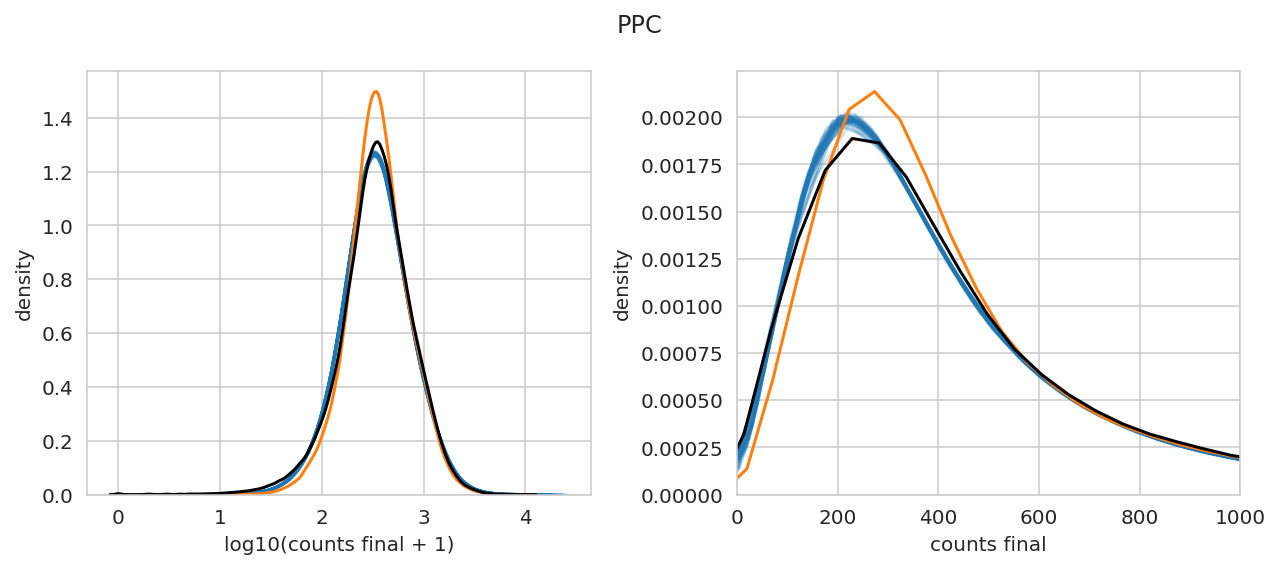

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=False, sharey=False)
ax1 = axes[0]
ax2 = axes[1]

pp_avg = trace.posterior_predictive["ct_final"].mean(axis=(0, 1))

for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(
        x=np.log10(example_ppc_draws[i, :] + 1), alpha=0.2, color="tab:blue", ax=ax1
    )

sns.kdeplot(x=np.log10(pp_avg + 1), color="tab:orange", ax=ax1)
sns.kdeplot(x=np.log10(valid_prostate_data["counts_final"] + 1), color="k", ax=ax1)
ax1.set_xlabel("log10(counts final + 1)")
ax1.set_ylabel("density")


for i in range(example_ppc_draws.shape[0]):
    sns.kdeplot(x=example_ppc_draws[i, :], alpha=0.2, color="tab:blue", ax=ax2)

sns.kdeplot(x=pp_avg, color="tab:orange", ax=ax2)
sns.kdeplot(x=valid_prostate_data["counts_final"], color="k", ax=ax2)
ax2.set_xlabel("counts final")
ax2.set_ylabel("density")
ax2.set_xlim(0, 1000)

fig.suptitle("PPC")
fig.tight_layout()
plt.show()

---

## Session info

In [31]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 7.05 minutes


In [32]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-07-24

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-164.o2.rc.hms.harvard.edu

Git branch: simplify

qnorm     : 0.8.1
matplotlib: 3.5.2
numpy     : 1.22.4
arviz     : 0.12.1
seaborn   : 0.11.2
pandas    : 1.4.3

